In [ ]:
pip install kaggle pyspark matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=aaff6b6b9625006d03a5d6f1c25bc4c7006add92f1c81b561b2c373a6d607f9b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import os
import subprocess
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

dataset_identifier = 'aadarshvelu/liver-cirrhosis-stage-classification'
subprocess.run(['kaggle', 'datasets', 'download', '-d', dataset_identifier, '-p', './'])

import zipfile
with zipfile.ZipFile('./liver-cirrhosis-stage-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

extracted_files = os.listdir('./')
print("Extracted files:", extracted_files)

csv_file = [file for file in extracted_files if file.endswith('.csv')][0]
file_path = f'./{csv_file}'
print("CSV File Path:", file_path)


Extracted files: ['.config', 'liver-cirrhosis-stage-classification.zip', 'liver_cirrhosis.csv', 'sample_data']
CSV File Path: ./liver_cirrhosis.csv


In [ ]:
spark = SparkSession.builder \
    .appName("Liver Cirrhosis Stage Classification") \
    .getOrCreate()

df = spark.read.csv(file_path, header=True, inferSchema=True)

df.printSchema()
df.show(20)

root
 |-- N_Days: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Drug: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ascites: string (nullable = true)
 |-- Hepatomegaly: string (nullable = true)
 |-- Spiders: string (nullable = true)
 |-- Edema: string (nullable = true)
 |-- Bilirubin: double (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- Albumin: double (nullable = true)
 |-- Copper: double (nullable = true)
 |-- Alk_Phos: double (nullable = true)
 |-- SGOT: double (nullable = true)
 |-- Tryglicerides: double (nullable = true)
 |-- Platelets: double (nullable = true)
 |-- Prothrombin: double (nullable = true)
 |-- Stage: integer (nullable = true)

+------+------+-------+-----+---+-------+------------+-------+-----+---------+-----------+-------+----------+-----------+-----------+-------------+---------+-----------+-----+
|N_Days|Status|   Drug|  Age|Sex|Ascites|Hepatomegaly|Spiders|Edema|Bil

In [ ]:
null_counts_dict = {col_name: df.filter(col(col_name).isNull()).count() for col_name in df.columns}

null_counts_df = pd.DataFrame(list(null_counts_dict.items()), columns=['Column', 'Null Values'])

print(null_counts_df)

           Column  Null Values
0          N_Days            0
1          Status            0
2            Drug            0
3             Age            0
4             Sex            0
5         Ascites            0
6    Hepatomegaly            0
7         Spiders            0
8           Edema            0
9       Bilirubin            0
10    Cholesterol            0
11        Albumin            0
12         Copper            0
13       Alk_Phos            0
14           SGOT            0
15  Tryglicerides            0
16      Platelets            0
17    Prothrombin            0
18          Stage            0


In [ ]:
# Data preprocessing

df_cleaned.groupBy("Stage").count().show()

df_cleaned = df_cleaned.withColumn("Age_Years", df_cleaned["Age"] / 365)

categorical_columns = [field for (field, dataType) in df_cleaned.dtypes if dataType == "string"]

indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed") for column in categorical_columns]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df_cleaned).transform(df_cleaned)

feature_columns = [column for column in df.columns if column != "Stage" and column not in categorical_columns and column != "Age"]
feature_columns.append("Age_Years")
feature_columns += [column+"_indexed" for column in categorical_columns]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="unscaled_features")
df_assembled = assembler.transform(df_indexed).select("unscaled_features", "Stage")

scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
df_final = scaler.fit(df_assembled).transform(df_assembled).select("features", "Stage")

train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=1234)

+-----+-----+
|Stage|count|
+-----+-----+
|    1| 8265|
|    3| 8294|
|    2| 8441|
+-----+-----+



In [ ]:
#Model Definition
dt = DecisionTreeClassifier(labelCol="Stage")
rf = RandomForestClassifier(labelCol="Stage")

param_grid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15, 20]) \
    .build()

param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 15, 20]) \
    .build()

dt_pipeline = Pipeline(stages=[dt])
rf_pipeline = Pipeline(stages=[rf])

crossval_dt = CrossValidator(estimator=dt_pipeline,
                             estimatorParamMaps=param_grid_dt,
                             evaluator=MulticlassClassificationEvaluator(labelCol="Stage", predictionCol="prediction", metricName="accuracy"),
                             numFolds=3)

crossval_rf = CrossValidator(estimator=rf_pipeline,
                             estimatorParamMaps=param_grid_rf,
                             evaluator=MulticlassClassificationEvaluator(labelCol="Stage", predictionCol="prediction", metricName="accuracy"),
                             numFolds=3)

# Model Training
dt_model = crossval_dt.fit(train_data)
rf_model = crossval_rf.fit(train_data)

dt_predictions = dt_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)

#Model Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="Stage", predictionCol="prediction", metricName="accuracy")

dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")


Decision Tree Accuracy: 0.9128081779915814
Random Forest Accuracy: 0.9538985768691121


Decision Tree Accuracy: 0.9128081779915814
Decision Tree Precision: 0.9129407949462736
Decision Tree Recall: 0.9128081779915814
Decision Tree F1-Score: 0.9128582510245298

Random Forest Accuracy: 0.9538985768691121
Random Forest Precision: 0.9539406676489
Random Forest Recall: 0.9538985768691121
Random Forest F1-Score: 0.9538799325230588


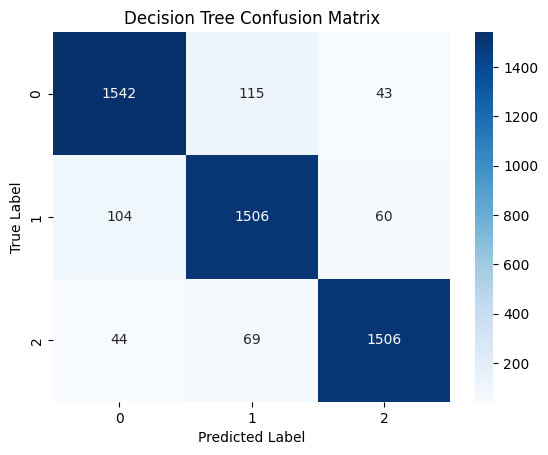

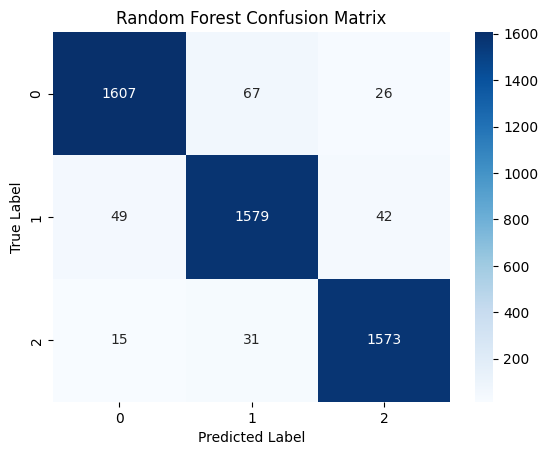

In [ ]:
def plot_confusion_matrix(predictions, title):
    y_true = predictions.select("Stage").collect()  
    y_pred = predictions.select("prediction").collect()

    y_true = np.array([row[0] for row in y_true])
    y_pred = np.array([row[0] for row in y_pred])

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

def calculate_metrics(predictions):
    y_true = predictions.select("Stage").collect()  
    y_pred = predictions.select("prediction").collect()

    y_true = np.array([row[0] for row in y_true])
    y_pred = np.array([row[0] for row in y_pred])

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return precision, recall, f1

dt_precision, dt_recall, dt_f1 = calculate_metrics(dt_predictions)
rf_precision, rf_recall, rf_f1 = calculate_metrics(rf_predictions)

print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Decision Tree Precision: {dt_precision}")
print(f"Decision Tree Recall: {dt_recall}")
print(f"Decision Tree F1-Score: {dt_f1}\n")

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest Precision: {rf_precision}")
print(f"Random Forest Recall: {rf_recall}")
print(f"Random Forest F1-Score: {rf_f1}")

plot_confusion_matrix(dt_predictions, "Decision Tree Confusion Matrix")
plot_confusion_matrix(rf_predictions, "Random Forest Confusion Matrix")


In [ ]:
train_data.printSchema()
train_data.describe().show()

train_data.show(5)

root
 |-- features: vector (nullable = true)
 |-- Stage: integer (nullable = true)

+-------+------------------+
|summary|             Stage|
+-------+------------------+
|  count|             20011|
|   mean|2.0054969766628354|
| stddev|0.8134119172687263|
|    min|                 1|
|    max|                 3|
+-------+------------------+

+--------------------+-----+
|            features|Stage|
+--------------------+-----+
|[0.03755641760062...|    3|
|[0.03755641760062...|    1|
|[0.03755641760062...|    1|
|[0.03755641760062...|    1|
|[0.03755641760062...|    1|
+--------------------+-----+
only showing top 5 rows



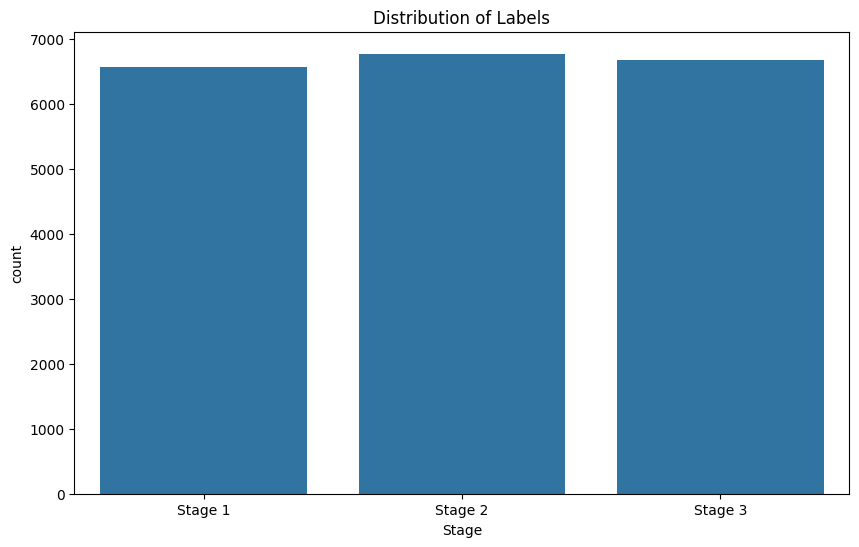

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_df = train_data.toPandas()

plt.figure(figsize=(10, 6))
sns.countplot(x='Stage', data=train_df) 
plt.title('Distribution of Labels')
plt.xticks(ticks=[0, 1, 2], labels=['Stage 1', 'Stage 2', 'Stage 3'])
plt.show()


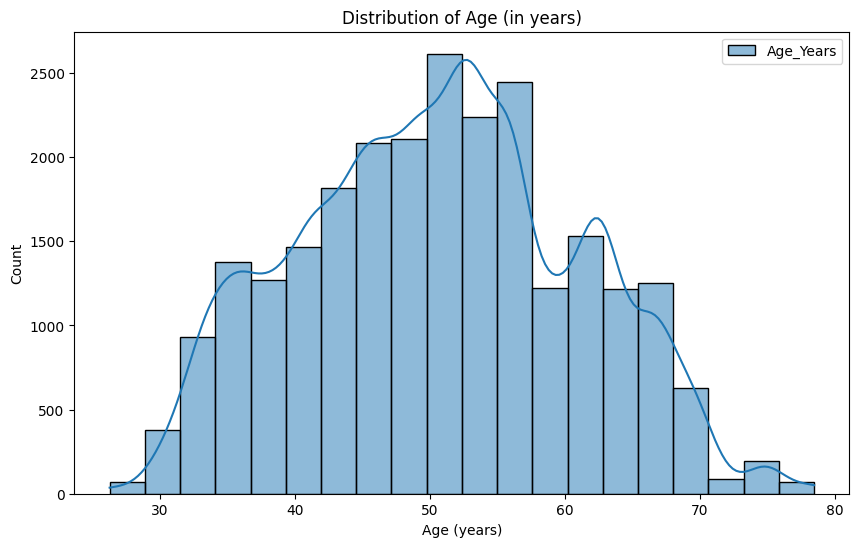

<ipython-input-17-48c446113aad>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=df_cleaned.toPandas(), palette='pastel')


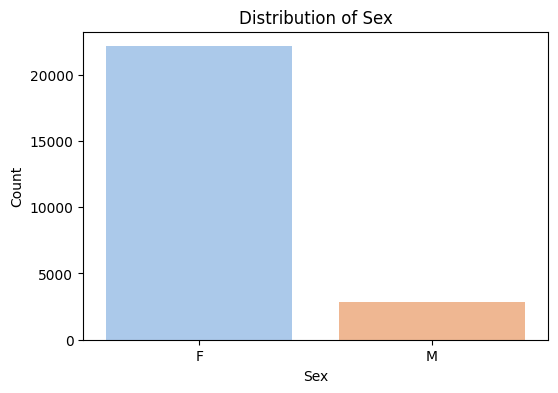

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cleaned = df_cleaned.withColumn('Age_Years', df_cleaned['Age'] / 365.0)

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned.select('Age_Years').toPandas(), bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age (in years)')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=df_cleaned.toPandas(), palette='pastel')
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


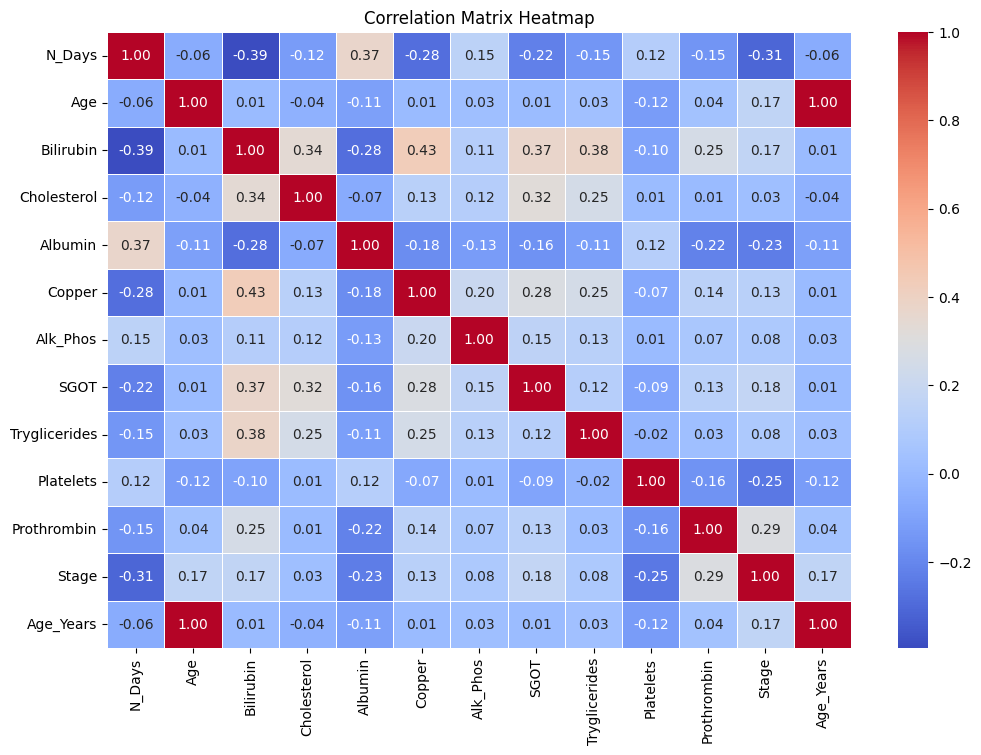

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = [col for col in df_cleaned.columns if df_cleaned.select(col).dtypes[0][1] != 'string']

correlation_matrix = df_cleaned.select(numeric_columns).toPandas().corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


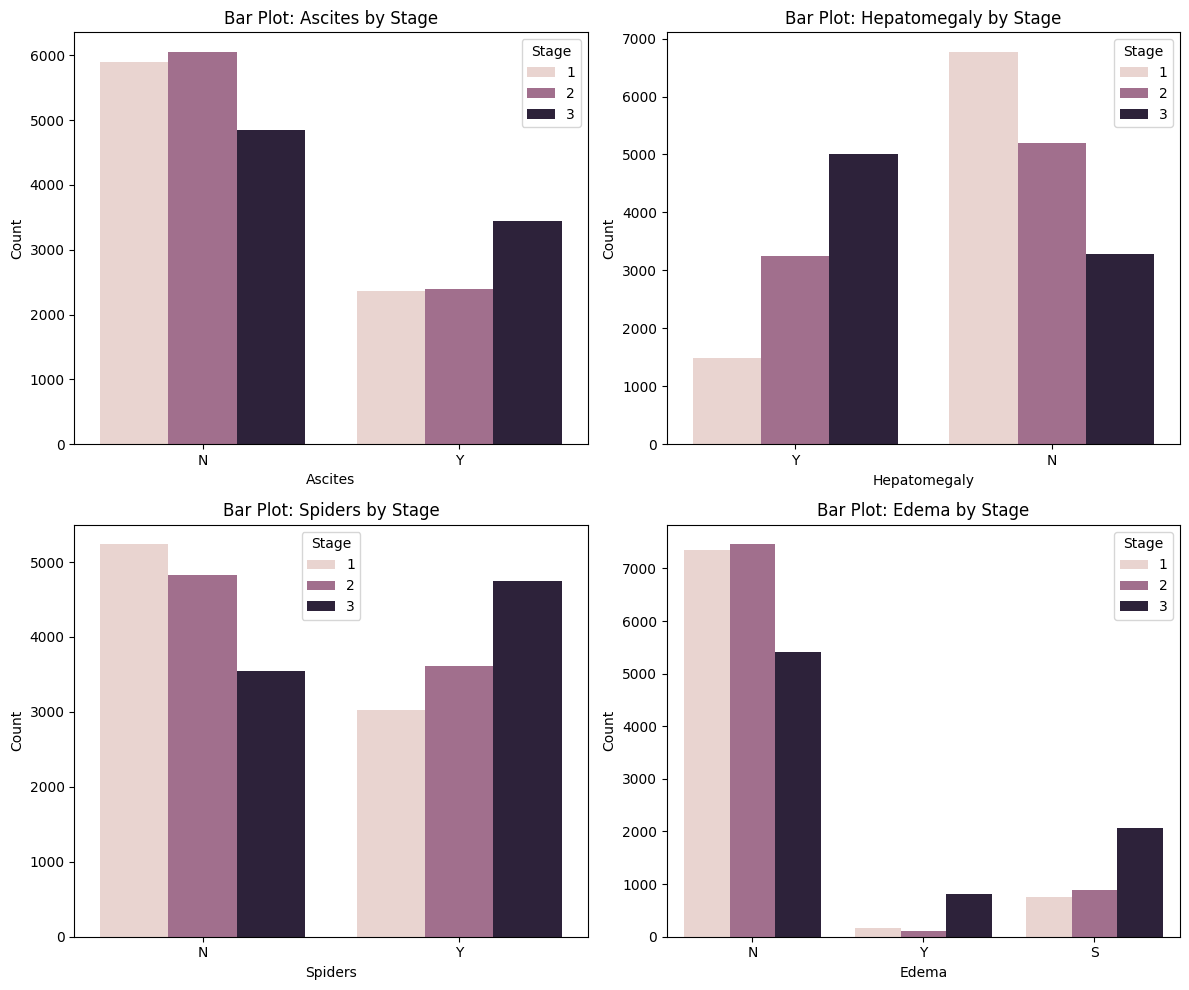

In [ ]:
categorical_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, hue='Stage', data=df_cleaned.toPandas(), ax=axes[i])
    axes[i].set_title(f'Bar Plot: {col} by Stage')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Stage')

plt.tight_layout()
plt.show()

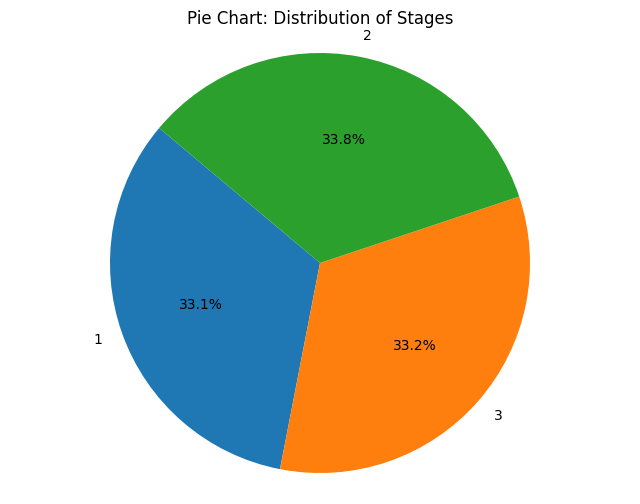

In [ ]:
stage_counts = df_cleaned.groupBy('Stage').count().toPandas()
plt.figure(figsize=(8, 6))
plt.pie(stage_counts['count'], labels=stage_counts['Stage'], autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart: Distribution of Stages')
plt.axis('equal')
plt.show()

In [ ]:
spark.stop()